# <center> <u> GRU - Rolling Prediction

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [15]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [18]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [118]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_26898/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [119]:
df = df[['timestamp','net_load']]

In [120]:
df.rename(columns={'timestamp':'ts'},inplace=True)
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)
df

,net_load
ts,
2019-04-01 00:00:00+00:00,14.620
2019-04-01 00:30:00+00:00,16.700
2019-04-01 01:00:00+00:00,20.270
2019-04-01 01:30:00+00:00,15.870
2019-04-01 02:00:00+00:00,15.120
...,...
2020-03-31 20:30:00+00:00,14.390
2020-03-31 21:00:00+00:00,14.710
2020-03-31 21:30:00+00:00,14.950


## Normalise the Data

<Axes: xlabel='ts'>

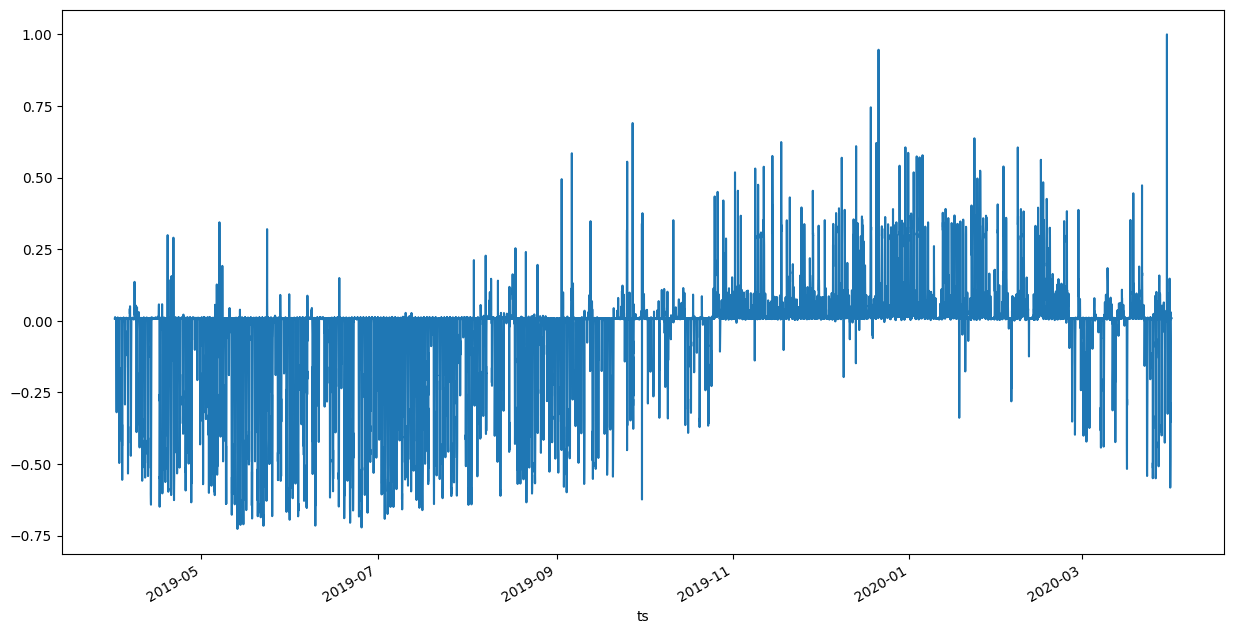

In [121]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

plt.figure(figsize=(15,8))
df['net_load_norm'].plot()

## Create the Lags and Prepare Data for GRU Model

In [122]:
lags = [1, 2, 48, 96]
for lag in lags:
    df[f'lag_{lag}'] = df['net_load_norm'].shift(lag)

In [123]:
df.dropna(inplace=True)

In [124]:
X = df[['lag_1', 'lag_2', 'lag_48', 'lag_96']].values
y = df['net_load_norm'].values

In [125]:
X_train, X_test = X[:-72], X[-72:]
y_train, y_test = y[:-72], y[-72:]

In [126]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [127]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - loss: 0.0079
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0047
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0045
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 0.0043
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0040
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0040
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - loss: 0.0040
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 0.0038
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - loss: 0.0040
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - loss: 0.0037


In [194]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [-1 - lag for lag in lags]
    # Use numpy indexing to get values at positions
    return ts[positions].reshape(1,len(lags),1)

In [183]:
x_input = X_test[0].reshape(1, X_test.shape[1], 1)

In [191]:
ts.shape

(17371,)

In [185]:
x_input

array([[[-0.00292527],
        [ 0.00011765],
        [ 0.03563273],
        [ 0.00641207]]])

In [196]:
model.predict(get_input(ts,lags))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[0.01383892]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

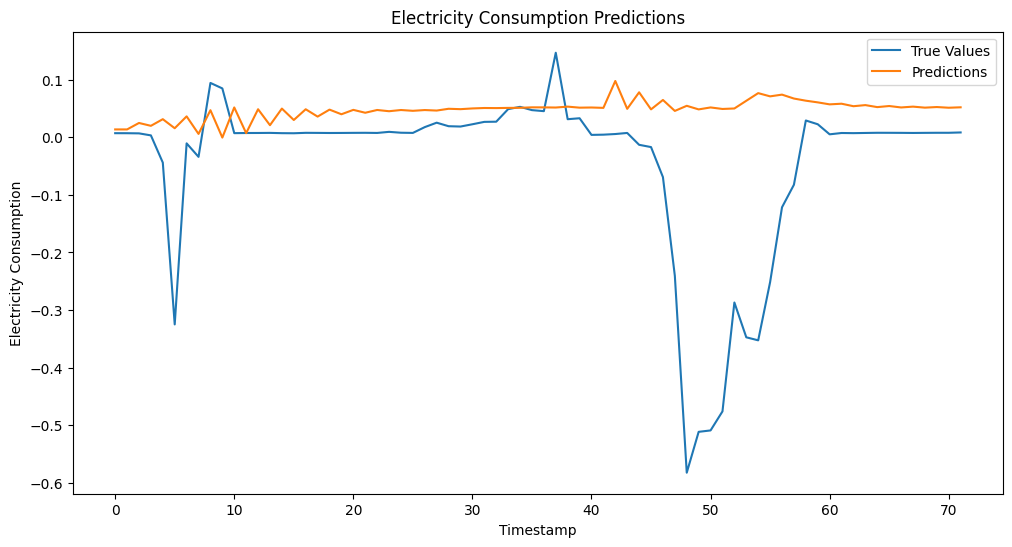

In [197]:
predictions = []
ts = y_train.copy()

# Iterate over each timestamp in the test set
for i in range(len(X_test)):
    x_input = get_input(ts,lags)
    pred_value = model.predict(x_input)
    ts=np.append(ts,pred_value)
    # Store the prediction
    predictions.append(pred_value)

# Convert the list of predictions to numpy array
predictions = np.array(predictions)

# Reshape the predictions array if needed
predictions = predictions.reshape(predictions.shape[0], 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Predictions')
plt.legend()
plt.show()

timeseries
hacer que el test dataset sean los ultimos 30 dias. hacer append de los originales despues de 36 horas y repetir el proceso.

Predecir con la funcion de arriba para 36 horas, y despues añadir.